### Importe de librerias 


In [36]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [1]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch 

In [38]:
import torch
print("CUDA disponible:", torch.cuda.is_available())
print("Nombre GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No hay GPU")


CUDA disponible: True
Nombre GPU: NVIDIA GeForce RTX 3050 Laptop GPU


### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [2]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4) #Simulador de estados mixtos

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [3]:

@qml.qnode(dev, interface='torch') #Decorador para definir el circuito cuántico

def Circuit(params, rho):
    # Crear estado |00⟩⟨00| como matriz densidad 4x4 (2 qubits)
    rho_00 = torch.zeros((4, 4), dtype=torch.complex128)
    rho_00[0, 0] = 1.0

    # Producto tensorial: estado total 4 qubits = |00⟩⟨00| ⊗ ρ
    full_state = torch.kron(rho_00, rho)  # full_state es 16x16

    # Preparar estado en el dispositivo
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])

    # Primera capa de rotaciones
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)

    # Interacción y control
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)

    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)

    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    return qml.probs(wires=[0, 1])




### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [4]:
def ρ1(a):
    """Genera un estado puro de la familia 1 (ρ1) como torch.Tensor"""
    # a es float o tensor escalar
    a = a.detach().clone().type(torch.float64).requires_grad_(True)

    psi1 = torch.tensor([
        torch.sqrt(1 - a * a),
        0.0,
        a,
        0.0
    ], dtype=torch.complex128)

    rho1 = torch.outer(psi1, torch.conj(psi1))  # matriz densidad 4x4
    return rho1, 1

def ρ2(b):
    """Genera un estado mixto de la familia 2 (ρ2) como torch.Tensor"""
    b = b.detach().clone().type(torch.float64).requires_grad_(True)


    psi2 = torch.tensor([
        0.0,
        torch.sqrt(1 - b * b),
        b,
        0.0
    ], dtype=torch.complex128)

    psi3 = torch.tensor([
        0.0,
        -torch.sqrt(1 - b * b),
        b,
        0.0
    ], dtype=torch.complex128)

    rho2 = 0.5 * torch.outer(psi2, torch.conj(psi2)) + \
           0.5 * torch.outer(psi3, torch.conj(psi3))

    return rho2, 2

    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [42]:
torch.manual_seed(2)
n_test = 10000
data_test = []

# Clase 1: rho1, etiqueta = 1
a_test = torch.distributions.Uniform(0.0, 1.0).sample((n_test // 2,))
for a in a_test:
    rho, label = ρ1(a)
    data_test.append((rho, label))

# Clase 2: rho2, etiqueta = 2
b_test = torch.distributions.Uniform(0.0, 1.0).sample((n_test // 2,))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))


In [43]:
print(data_test[-5:])

[(tensor([[0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0670+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.9330+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j]],
       dtype=torch.complex128), 2), (tensor([[0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.9103+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0897+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j]],
       dtype=torch.complex128), 2), (tensor([[0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.8228+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.1772+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j]],
       dtype=torch.complex128), 2), (tensor([[0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.2374+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.7626+0.j, 0.0000+0.j],
        [0.000

### Conjunto de Datos de Entrenamiento 


In [44]:
torch.manual_seed(1)
n_samples = 1000
data_train = []

# Familia 1 → usa ρ1(a), etiqueta = 1
a_values = torch.distributions.Uniform(0.0, 1.0).sample((n_samples // 2,))
for a in a_values:
    rho, label = ρ1(a)  # rho es tensor 4x4, label = 1
    data_train.append((rho, label))

# Familia 2 → usa ρ2(b), etiqueta = 2
b_values = torch.distributions.Uniform(0.0, 1.0).sample((n_samples // 2,))
for b in b_values:
    rho, label = ρ2(b)  # rho es tensor 4x4, label = 2
    data_train.append((rho, label))

from sklearn.model_selection import train_test_split

# Separar 80% entrenamiento, 20% validación
data_train, data_val = train_test_split(data_train, test_size=0.2, random_state=42)


In [45]:
print(data_train[-5:])

[(tensor([[0.0397+0.j, 0.0000+0.j, 0.1953+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.1953+0.j, 0.0000+0.j, 0.9603+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j]],
       dtype=torch.complex128), 1), (tensor([[0.5886+0.j, 0.0000+0.j, 0.4921+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.4921+0.j, 0.0000+0.j, 0.4114+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j]],
       dtype=torch.complex128), 1), (tensor([[0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.3347+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.6653+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j]],
       dtype=torch.complex128), 2), (tensor([[0.9905+0.j, 0.0000+0.j, 0.0968+0.j, 0.0000+0.j],
        [0.0000+0.j, 0.0000+0.j, 0.0000+0.j, 0.0000+0.j],
        [0.0968+0.j, 0.0000+0.j, 0.0095+0.j, 0.0000+0.j],
        [0.000

### Función de Pérdida 


In [5]:
alpha_err = 10
alpha_inc = 20

def sample_loss(params, rho, label):
    probs = Circuit(params, rho)  # probs debe ser un torch.Tensor de shape [4]

    if label == 1:
        p_suc = probs[0] + probs[2]
        p_err = probs[1]
        p_inc = probs[3]
    else:
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]

    return (
        torch.abs(p_suc - 1.0)
        + alpha_err * torch.abs(p_err)
        + alpha_inc * torch.abs(p_inc)
    )

def loss(params, samples):
    total = torch.tensor(0.0, dtype=torch.float64)  # ya no usamos requires_grad aquí
    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)
    return total / len(samples)  # torch.Tensor escalar


In [6]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [7]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""

    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0.0, 0.0, 0.0
    total_suc_2, total_err_2, total_inc_2 = 0.0, 0.0, 0.0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        probs = probs.detach().clone().requires_grad_(True)  
        total_suc_1 += probs[0] + probs[2]
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        probs = probs.detach().clone().requires_grad_(True)
        total_suc_2 += probs[1]
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc.item(), err.item(), inc.item()


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [49]:
n_iter = 500
batch_size = 16

initial_params = np.random.uniform(0, 2 * np.pi, 30)
param_tensor = torch.nn.Parameter(torch.tensor(initial_params, dtype=torch.float64)) 
opt = torch.optim.Adam([param_tensor], lr=0.01)

# Separar conjunto de validación (20%)
data_train, data_val = train_test_split(data_train, test_size=0.2, random_state=42)

# Early stopping
patience = 100
min_delta = 1e-6
best_val_loss = float("inf")
patience_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
test_suc_history = []
test_err_history = []
test_inc_history = []

# ----------------------------
# 2. Entrenamiento
# ----------------------------

for it in tqdm(range(n_iter), desc="Entrenando"):
    opt.zero_grad()

    # Barajar el conjunto de entrenamiento en cada época
    np.random.shuffle(data_train)
    
    # Dividir en mini-lotes
    num_batches = len(data_train) // batch_size
    total_batch_loss = 0.0

    for i in range(num_batches):
        batch = data_train[i * batch_size : (i + 1) * batch_size]
        batch_loss = loss(param_tensor, batch)
        batch_loss.backward()
        total_batch_loss += batch_loss.item()

    # Promedio sobre los mini-lotes
    avg_batch_loss = total_batch_loss / num_batches
    opt.step()

    # Validación
    with torch.no_grad():
        val_loss = loss(param_tensor, data_val).item()

    # Early stopping
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"⏹️ Early stopping en la iteración {it+1}. Mejor val_loss: {best_val_loss:.6f}")
        break

    # Métricas
    suc_train, err_train, inc_train = evaluate_model(param_tensor, data_train)
    suc_test, err_test, inc_test = evaluate_model(param_tensor, data_test)

    # Guardar historia
    loss_history.append(avg_batch_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    test_suc_history.append(suc_test)
    test_err_history.append(err_test)
    test_inc_history.append(inc_test)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d} | "
              f"train_loss={avg_batch_loss:.4f}  val_loss={val_loss:.4f} | "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"test_suc={suc_test:.3f}, test_err={err_test:.3f}, test_inc={inc_test:.3f}")

# ----------------------------
# 3. Resultados finales
# ----------------------------

print("Parámetros entrenados:")
print(param_tensor.detach().numpy())

print("Resultados finales en el conjunto de prueba:")
print(f"  Éxito promedio     = {suc_test:.4f}")
print(f"  Error promedio     = {err_test:.4f}")
print(f"  Inconcluso promedio = {inc_test:.4f}")



    




Entrenando:  10%|█         | 50/500 [2:33:54<23:26:48, 187.57s/it]

Iter  50 | train_loss=8.3115  val_loss=8.0074 | train_suc=0.472, train_err=0.286, train_inc=0.242 | test_suc=0.473, test_err=0.289, test_inc=0.238


Entrenando:  20%|██        | 100/500 [5:09:50<21:07:58, 190.20s/it]

Iter 100 | train_loss=6.4021  val_loss=6.0405 | train_suc=0.581, train_err=0.242, train_inc=0.177 | test_suc=0.584, test_err=0.244, test_inc=0.173


Entrenando:  30%|███       | 150/500 [7:53:08<18:53:49, 194.37s/it]

Iter 150 | train_loss=5.3754  val_loss=4.8993 | train_suc=0.688, train_err=0.118, train_inc=0.193 | test_suc=0.695, test_err=0.118, test_inc=0.187


Entrenando:  40%|████      | 200/500 [10:28:20<15:31:48, 186.36s/it]

Iter 200 | train_loss=4.5895  val_loss=4.0994 | train_suc=0.727, train_err=0.117, train_inc=0.156 | test_suc=0.734, test_err=0.115, test_inc=0.151


Entrenando:  50%|█████     | 250/500 [13:03:03<12:53:50, 185.72s/it]

Iter 250 | train_loss=2.8349  val_loss=2.3854 | train_suc=0.793, train_err=0.155, train_inc=0.052 | test_suc=0.802, test_err=0.147, test_inc=0.051


Entrenando:  60%|██████    | 300/500 [15:39:19<10:24:00, 187.20s/it]

Iter 300 | train_loss=1.9913  val_loss=1.5918 | train_suc=0.823, train_err=0.173, train_inc=0.004 | test_suc=0.833, test_err=0.163, test_inc=0.004


Entrenando:  70%|███████   | 350/500 [18:15:38<7:48:36, 187.44s/it] 

Iter 350 | train_loss=1.9185  val_loss=1.5253 | train_suc=0.826, train_err=0.174, train_inc=0.000 | test_suc=0.835, test_err=0.164, test_inc=0.000


Entrenando:  80%|████████  | 400/500 [20:54:03<5:24:03, 194.43s/it]

Iter 400 | train_loss=1.9165  val_loss=1.5236 | train_suc=0.826, train_err=0.174, train_inc=0.000 | test_suc=0.835, test_err=0.165, test_inc=0.000


Entrenando:  90%|█████████ | 450/500 [23:36:24<2:59:51, 215.83s/it]

Iter 450 | train_loss=1.9165  val_loss=1.5236 | train_suc=0.826, train_err=0.174, train_inc=0.000 | test_suc=0.835, test_err=0.165, test_inc=0.000


Entrenando: 100%|██████████| 500/500 [26:23:57<00:00, 190.07s/it]  

Iter 500 | train_loss=1.9165  val_loss=1.5236 | train_suc=0.826, train_err=0.174, train_inc=0.000 | test_suc=0.835, test_err=0.165, test_inc=0.000
Parámetros entrenados:
[ 5.51166093e-01  3.14158777e+00  3.25471919e-01  1.45531067e+00
  1.57078290e+00  6.28318525e+00 -6.62900375e-01  7.41715188e-01
  5.25170007e-01  1.72912749e+00  3.14159265e+00  3.71500371e+00
  5.58095814e+00  2.61208839e+00  1.18218321e+00  5.25498019e+00
  2.93686332e-01  3.77871429e-01  3.25475443e-01 -5.48173242e-06
  6.15497927e+00  3.29614589e+00  2.47091248e+00  1.75985153e+00
  7.16268204e-01  4.03054774e+00  4.53573472e+00 -3.25441038e-01
  6.28319008e+00  2.39806934e+00]
Resultados finales en el conjunto de prueba:
  Éxito promedio     = 0.8355
  Error promedio     = 0.1645
  Inconcluso promedio = 0.0000


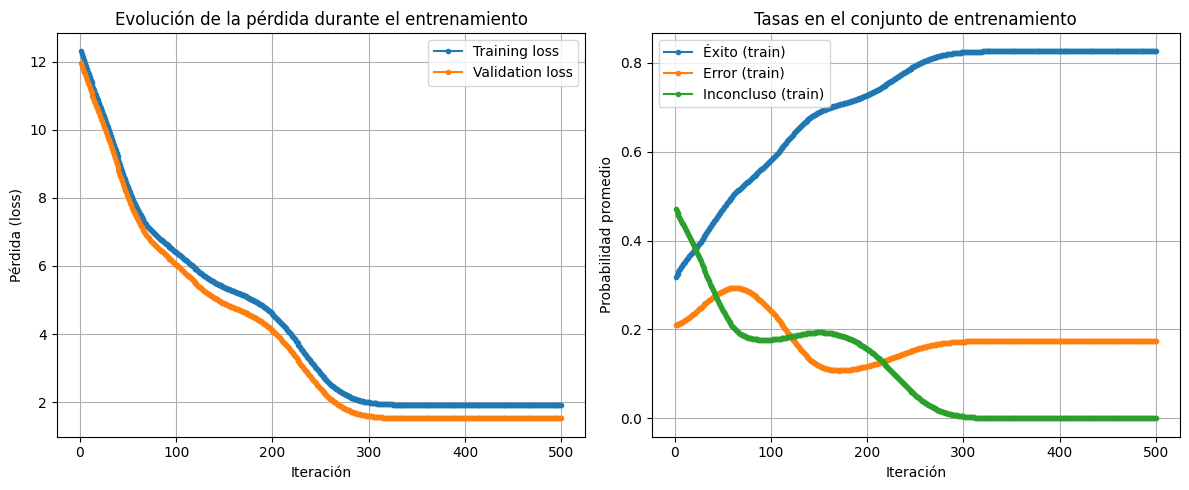

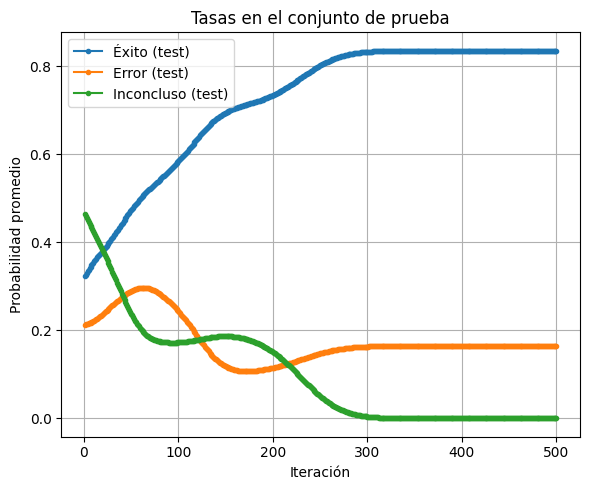

In [50]:
# Visualización de los resultados
plt.figure(figsize=(12,5))

# Evolución de la pérdida
plt.subplot(1,2,1)
plt.plot(range(1, it+2), loss_history, '.-', label="Training loss")
plt.plot(range(1, it+2), val_loss_history, '.-', label="Validation loss")
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la pérdida durante el entrenamiento")
plt.grid()
plt.legend()

# Éxito, Error e Inconcluso en train
plt.subplot(1,2,2)
plt.plot(range(1, it+2), train_suc_history, '.-', label="Éxito (train)")
plt.plot(range(1, it+2), train_err_history, '.-', label="Error (train)")
plt.plot(range(1, it+2), train_inc_history, '.-', label="Inconcluso (train)")
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas en el conjunto de entrenamiento")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Figura para test
plt.figure(figsize=(6,5))

# Éxito, Error e Inconcluso en test
plt.plot(range(1, it+2), test_suc_history, '.-', label="Éxito (test)")
plt.plot(range(1, it+2), test_err_history, '.-', label="Error (test)")
plt.plot(range(1, it+2), test_inc_history, '.-', label="Inconcluso (test)")
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas en el conjunto de prueba")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

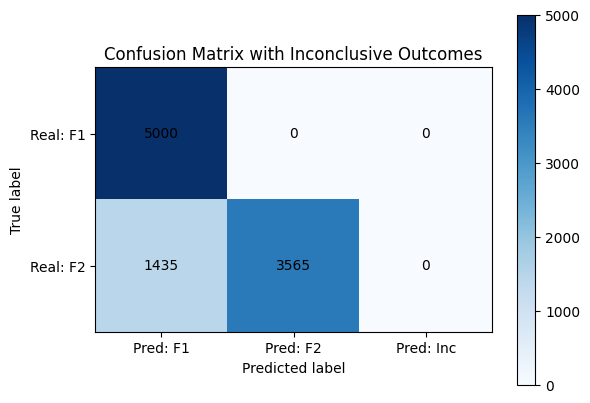

In [51]:
params=param_tensor
def predict_label(params, val, actual_label):
    """
    Predicción discreta:
    - 1: Familia 1
    - 2: Familia 2
    - 3: Inconcluso
    """
    if isinstance(params, torch.Tensor):
        params = params.detach().numpy()

    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    idx = np.argmax([p_fam1, p_fam2, p_inc])
    return [1, 2, 3][idx]

def confusion_matrix_inconclusive(params, samples):
    cm = np.zeros((2, 3))  # 2 filas (F1, F2), 3 columnas (predicciones)

    if isinstance(params, torch.Tensor):
        params = params.detach().numpy()

    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1
        col = pred - 1
        cm[row, col] += 1

    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum

    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred: F1", "Pred: F2", "Pred: Inc"])
    ax.set_yticklabels(["Real: F1", "Real: F2"])

    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            txt = f"{val:.0f}" if not normalize else f"{val*100:.1f}%"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Confusion Matrix with Inconclusive Outcomes")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

cm_test = confusion_matrix_inconclusive(param_tensor, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)


In [17]:
param_tensor=pnp.array([5.51166093e-01,  3.14158777e+00,  3.25471919e-01,  1.45531067e+00,
  1.57078290e+00,  6.28318525e+00, -6.62900375e-01,  7.41715188e-01,
  5.25170007e-01,  1.72912749e+00,  3.14159265e+00,  3.71500371e+00,
  5.58095814e+00,  2.61208839e+00,  1.18218321e+00,  5.25498019e+00,
  2.93686332e-01,  3.77871429e-01,  3.25475443e-01, -5.48173242e-06,
  6.15497927e+00,  3.29614589e+00,  2.47091248e+00,  1.75985153e+00,
  7.16268204e-01,  4.03054774e+00,  4.53573472e+00, -3.25441038e-01,
  6.28319008e+00,  2.39806934e+00,])

In [18]:
torch.manual_seed(2)
n_test = 10000
data_test = []

# Clase 1: rho1, etiqueta = 1
a_test = torch.zeros(n_test // 2)
for a in a_test:
    rho, label = ρ1(a)
    data_test.append((rho, label))

# Clase 2: rho2, etiqueta = 2
b_test = torch.distributions.Uniform(0.0, 1.0).sample((n_test // 2,))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

/home/dayana-henao/Escritorio/Trabajo-de-Grado/venv/lib/python3.12/site-packages/pennylane/math/interface_utils.py:136: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


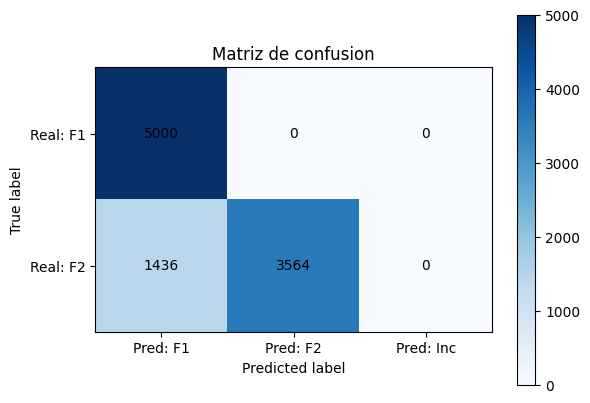

In [19]:
def predict_label(params, val, actual_label):
    """
    Predicción discreta:
    - 1: Familia 1
    - 2: Familia 2
    - 3: Inconcluso
    """
    if isinstance(params, torch.Tensor):
        params = params.detach().numpy()

    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    idx = np.argmax([p_fam1, p_fam2, p_inc])
    return [1, 2, 3][idx]

def confusion_matrix_inconclusive(params, samples):
    cm = np.zeros((2, 3))  # 2 filas (F1, F2), 3 columnas (predicciones)

    if isinstance(params, torch.Tensor):
        params = params.detach().numpy()

    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1
        col = pred - 1
        cm[row, col] += 1

    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum

    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred: F1", "Pred: F2", "Pred: Inc"])
    ax.set_yticklabels(["Real: F1", "Real: F2"])

    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            txt = f"{val:.0f}" if not normalize else f"{val*100:.1f}%"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusion")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

cm_test = confusion_matrix_inconclusive(param_tensor, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)

In [20]:
torch.manual_seed(2)
n_test = 10000
data_test = []

# Clase 1: rho1, etiqueta = 1
a_test = torch.distributions.Uniform(0.0, 1.0).sample((n_test // 2,))
for a in a_test:
    rho, label = ρ1(a)
    data_test.append((rho, label))

# Clase 2: rho2, etiqueta = 2
b_test = torch.zeros(n_test // 2)
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

/home/dayana-henao/Escritorio/Trabajo-de-Grado/venv/lib/python3.12/site-packages/pennylane/math/interface_utils.py:136: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


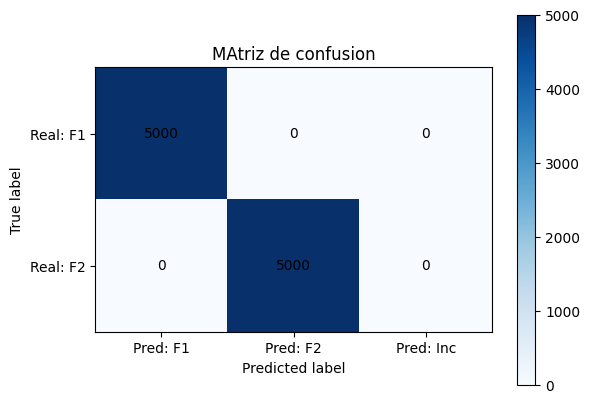

In [21]:
def predict_label(params, val, actual_label):
    """
    Predicción discreta:
    - 1: Familia 1
    - 2: Familia 2
    - 3: Inconcluso
    """
    if isinstance(params, torch.Tensor):
        params = params.detach().numpy()

    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    idx = np.argmax([p_fam1, p_fam2, p_inc])
    return [1, 2, 3][idx]

def confusion_matrix_inconclusive(params, samples):
    cm = np.zeros((2, 3))  # 2 filas (F1, F2), 3 columnas (predicciones)

    if isinstance(params, torch.Tensor):
        params = params.detach().numpy()

    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1
        col = pred - 1
        cm[row, col] += 1

    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum

    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    ax.set_xticks([0, 1, 2])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred: F1", "Pred: F2", "Pred: Inc"])
    ax.set_yticklabels(["Real: F1", "Real: F2"])

    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            txt = f"{val:.0f}" if not normalize else f"{val*100:.1f}%"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("MAtriz de confusion")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

cm_test = confusion_matrix_inconclusive(param_tensor, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)